In [1]:
import os, json, csv, textwrap, pathlib
pathlib.Path("../tests").mkdir(parents=True, exist_ok=True)

questions = [
    {"query":"Who is the CEO of Microsoft?"},
    {"query":"When did the James Webb Space Telescope launch?"},
    {"query":"Distance from Earth to the Moon in km"},
    {"query":"What is the capital of Japan?"},
    {"query":"What does GDP stand for?"},
    {"query":"Who founded Tesla Motors?"},
    {"query":"Height of Mount Everest in meters"},
    {"query":"When did World War II end?"},
    {"query":"What is the boiling point of water in Celsius?"},
    {"query":"Who is the current UN Secretary-General?"},
    {"query":"What is the chemical symbol for gold?"},
    {"query":"Largest ocean on Earth"},
    {"query":"Population of the United States (approx)"},
    {"query":"Who discovered penicillin?"},
    {"query":"Where is the Taj Mahal located?"},
    {"query":"Speed of light in vacuum (m/s)"},
    {"query":"Who wrote 'Pride and Prejudice'?"},
    {"query":"What currency is used in the UK?"},
    {"query":"What is the capital city of Canada?"},
    {"query":"What does HTTP stand for?"}
]

with open("tests/sample_questions.jsonl","w",encoding="utf-8") as f:
    for q in questions:
        f.write(json.dumps(q, ensure_ascii=False)+"\n")
print("Wrote ../tests/sample_questions.jsonl with", len(questions), "items")


Wrote ../tests/sample_questions.jsonl with 20 items


In [2]:
gold = [
    ["Who is the CEO of Microsoft?"," Satya Nadella"],
    ["When did the James Webb Space Telescope launch?","2021"],
    ["Distance from Earth to the Moon in km","384"],  # allow approx substring
    ["What is the capital of Japan?","Tokyo"],
    ["What does GDP stand for?","Gross Domestic Product"],
    ["Who founded Tesla Motors?","Elon"],             # simple contains
    ["Height of Mount Everest in meters","8848"],
    ["When did World War II end?","1945"],
    ["What is the boiling point of water in Celsius?","100"],
    ["Who is the current UN Secretary-General?","Guterres"],
    ["What is the chemical symbol for gold?","Au"],
    ["Largest ocean on Earth","Pacific"],
    ["Population of the United States (approx)","million"],  # substring
    ["Who discovered penicillin?","Fleming"],
    ["Where is the Taj Mahal located?","Agra"],
    ["Speed of light in vacuum (m/s)","299792458"],
    ["Who wrote 'Pride and Prejudice'?","Austen"],
    ["What currency is used in the UK?","Pound"],
    ["What is the capital city of Canada?","Ottawa"],
    ["What does HTTP stand for?","Hypertext Transfer Protocol"]
]

with open("tests/small_goldset.csv","w",newline="",encoding="utf-8") as f:
    w = csv.writer(f); w.writerow(["query","expected_contains"]); w.writerows(gold)
print("Wrote ../tests/small_goldset.csv")


Wrote ../tests/small_goldset.csv


In [8]:

def ask(query: str):
    r = Retriever()

    evidence = r.gather(query, max_per_source=4)
    
    sentences = []
    for e in evidence:
        first = (sent_tokenize(e.text) or [e.text[:200]])[0]
        sentences.append(first)
    
    claims = verify_sentences(sentences, evidence)
    answer = build_cited_answer(claims, evidence)
    bib = bibliography(evidence)
    record_path = write_decision_record(query, claims, evidence)
    
    return AskResponse(
        query=query,
        answer=answer + "\n\n" + bib,
        claims=claims,
        evidence=evidence,
        valid_as_of=datetime.utcnow(),
        decision_record_path=record_path
    )


In [9]:
import json, pandas as pd, time
from askme.evaluator import score_responses
from askme import settings
from pathlib import Path

# (tighten verification a bit for experiments
settings.verification_similarity = 0.65   # default ~0.60
settings.numeric_tolerance_pct  = 0.08    # default ~0.10


In [10]:
from collections import Counter
from nltk.tokenize import sent_tokenize

def run_batch(eval_path="tests/sample_questions.jsonl"):
    rows = []
    with open(eval_path,"r",encoding="utf-8") as f:
        for line in f:
            q = json.loads(line)["query"]
            t0 = time.time()
            r = ask(q)                          # uses existing ask() function
            dt = time.time() - t0

            labels = Counter(c.label for c in r.claims)
            num_sources = len(r.evidence)
            domains = { (e.source or "") for e in r.evidence }
            rows.append({
                "query": q,
                "latency_s": round(dt,2),
                "num_sources": num_sources,
                "unique_domains": len(domains),
                "verified": labels.get("Verified",0),
                "uncertain": labels.get("Uncertain",0),
                "unverifiable": labels.get("Unverifiable",0),
                "answer_text": r.answer
            })
    df = pd.DataFrame(rows)
    df.to_csv("tests/results_raw.csv", index=False)
    return df

df = run_batch()
df.head()


,query,latency_s,num_sources,unique_domains,verified,uncertain,unverifiable,answer_text
0,Who is the CEO of Microsoft?,8.24,5,3,0,0,5,Microsoft Gaming is an American multinational ...
1,When did the James Webb Space Telescope launch?,7.39,4,2,0,0,4,The James Webb Space Telescope (JWST) is a spa...
2,Distance from Earth to the Moon in km,7.77,4,3,0,0,4,"The instantaneous Earth–Moon distance, or dist..."
3,What is the capital of Japan?,25.60,4,2,0,0,4,Capital punishment is a legal penalty in Japan...
4,What does GDP stand for?,7.07,6,4,0,0,6,The parable of the broken window was introduce...


In [11]:
gold_df = pd.read_csv("tests/small_goldset.csv")
merged = df.merge(gold_df, on="query", how="left")

def contains_check(ans, needle):
    if pd.isna(needle): return None
    return int(str(needle).lower() in str(ans).lower())

merged["contains_hit"] = merged.apply(lambda r: contains_check(r["answer_text"], r["expected_contains"]), axis=1)
merged.to_csv("tests/results_scored.csv", index=False)
merged[["query","contains_hit","verified","uncertain","unverifiable","num_sources","unique_domains"]].head(10)


,query,contains_hit,verified,uncertain,unverifiable,num_sources,unique_domains
0,Who is the CEO of Microsoft?,1,0,0,5,5,3
1,When did the James Webb Space Telescope launch?,1,0,0,4,4,2
2,Distance from Earth to the Moon in km,1,0,0,4,4,3
3,What is the capital of Japan?,1,0,0,4,4,2
4,What does GDP stand for?,1,0,0,6,6,4
5,Who founded Tesla Motors?,1,0,0,4,4,3
6,Height of Mount Everest in meters,0,0,0,6,6,4
7,When did World War II end?,1,0,0,6,6,4
8,What is the boiling point of water in Celsius?,1,0,0,6,6,4
9,Who is the current UN Secretary-General?,1,0,0,5,5,2


In [12]:

summary = {
    "N": len(merged),
    "contains_hit_rate(%)": round(100*merged["contains_hit"].mean(),1),
    "avg_sources": round(merged["num_sources"].mean(),2),
    "avg_unique_domains": round(merged["unique_domains"].mean(),2),
    "avg_verified_claims": round(merged["verified"].mean(),2),
    "avg_uncertain_claims": round(merged["uncertain"].mean(),2),
    "avg_unverifiable_claims": round(merged["unverifiable"].mean(),2),
}
summary

pd.DataFrame(summary.items(), columns=["Metric", "Value"])


,Metric,Value
0,N,20.00
1,contains_hit_rate(%),85.00
2,avg_sources,5.05
3,avg_unique_domains,3.35
4,avg_verified_claims,0.05
5,avg_uncertain_claims,0.15
6,avg_unverifiable_claims,4.65


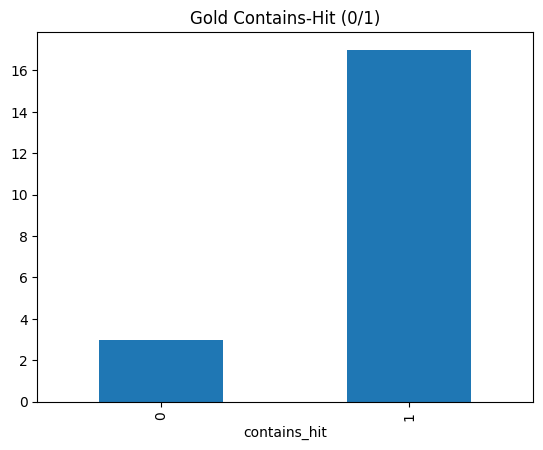

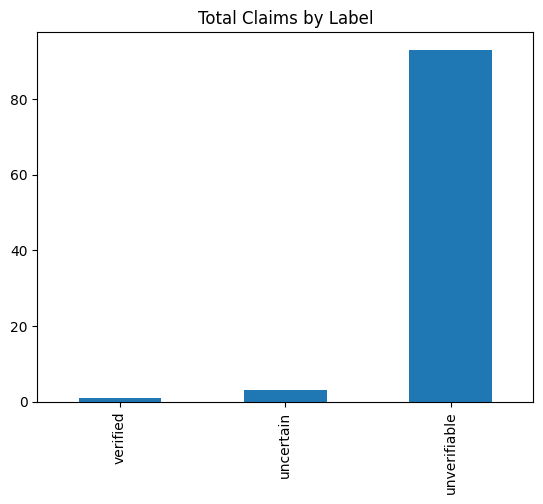

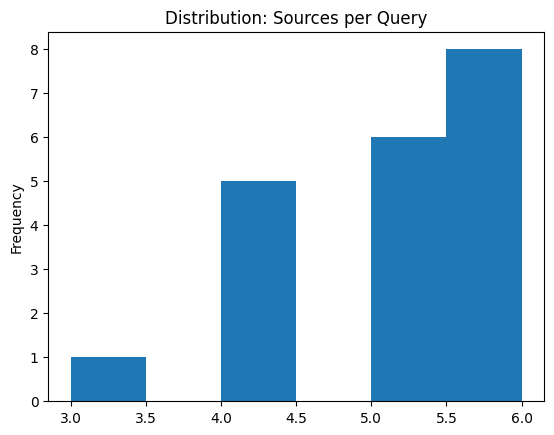

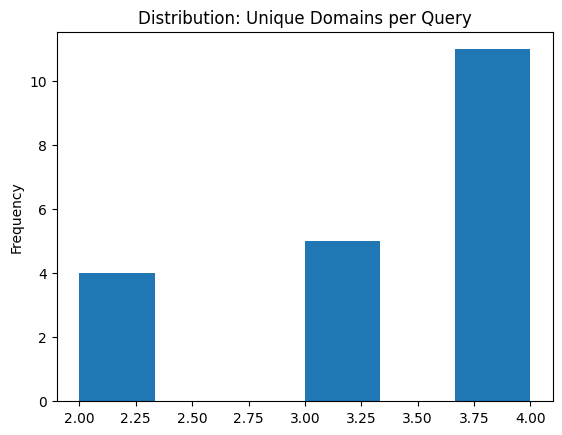

In [13]:
import matplotlib.pyplot as plt

merged["contains_hit"].value_counts().sort_index().plot(kind="bar", title="Gold Contains-Hit (0/1)")
plt.show()

merged[["verified","uncertain","unverifiable"]].sum().plot(kind="bar", title="Total Claims by Label")
plt.show()

merged["num_sources"].plot(kind="hist", bins=6, title="Distribution: Sources per Query")
plt.show()

merged["unique_domains"].plot(kind="hist", bins=6, title="Distribution: Unique Domains per Query")
plt.show()


In [14]:
from askme.retrieval import Retriever

def baseline_wikipedia_only(q):
    r = Retriever()
    ev = r.wp.get_evidence(q, max_results=1)
    if not ev: return ""
    first = (sent_tokenize(ev[0].text) or [ev[0].text[:200]])[0]
    return first

base_rows = []
for q in merged["query"]:
    ans = baseline_wikipedia_only(q)
    base_rows.append({"query": q, "baseline_answer": ans})
base = pd.DataFrame(base_rows)

merged2 = merged.merge(base, on="query", how="left")

def contains_baseline(ans, needle):
    if pd.isna(needle): return None
    return int(str(needle).lower() in str(ans).lower())

merged2["baseline_contains_hit"] = merged2.apply(lambda r: contains_baseline(r["baseline_answer"], r["expected_contains"]), axis=1)

comp = {
    "AskMe_contains_hit(%)": round(100*merged2["contains_hit"].mean(),1),
    "Baseline_contains_hit(%)": round(100*merged2["baseline_contains_hit"].mean(),1),
    "AskMe_avg_sources": round(merged2["num_sources"].mean(),2),
    "AskMe_avg_unique_domains": round(merged2["unique_domains"].mean(),2)
}
pd.DataFrame(comp.items(), columns=["Metric","Value"])


,Metric,Value
0,AskMe_contains_hit(%),85.00
1,Baseline_contains_hit(%),20.00
2,AskMe_avg_sources,5.05
3,AskMe_avg_unique_domains,3.35


In [15]:
summary_path = "tests/summary_metrics.csv"
pd.DataFrame(summary.items(), columns=["Metric","Value"]).to_csv(summary_path, index=False)
print("Saved summary to", summary_path)


Saved summary to tests/summary_metrics.csv
